New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`geom_smooth()` using formula 'y ~ x'



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
30,rmse,standard,4.415603,5,0.1260571,Preprocessor1_Model03


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.691381


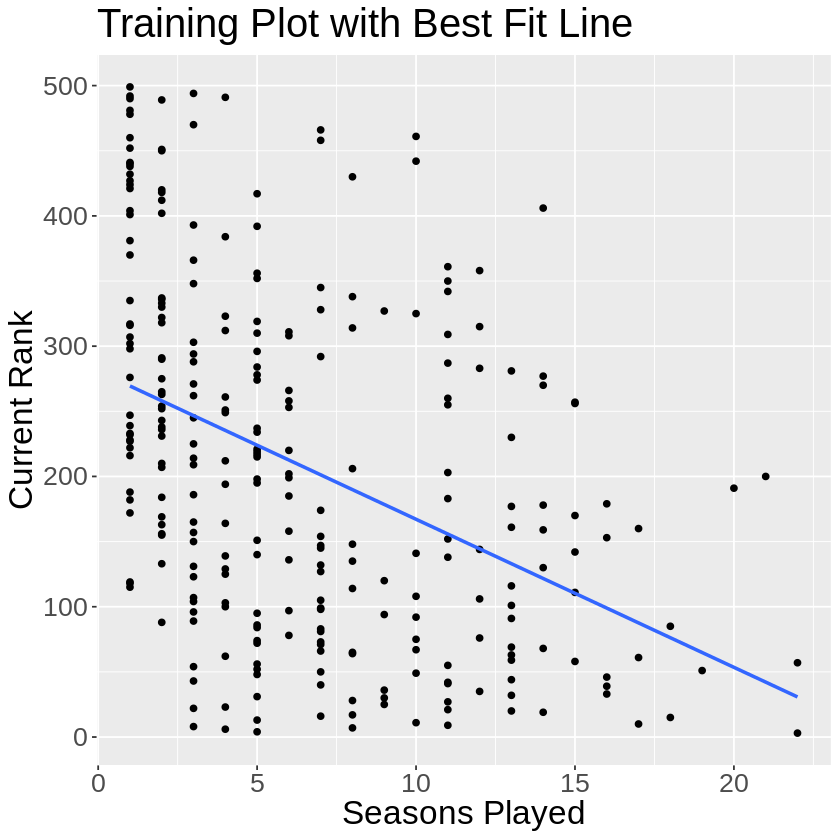

In [17]:
library(tidyverse)
library(tidymodels)

# set seed
set.seed(100)

# read and tidy data
player_stats <- read_csv("player_stats.csv")
colnames(player_stats)[colnames(player_stats) == "Current Rank"] <- "Current_Rank"
player_stats <- player_stats |>
    separate(col = Current_Rank, into = c("current_rank", "other_rank"), sep = " ", convert = TRUE) |>
    filter(Seasons != " ") |>
    filter(current_rank != "NA")|>
    select(Seasons, current_rank)

# split it into training and testing datasets
player_split <- initial_split(player_stats, prop = 0.75, strata = Seasons)
player_train <- training(player_split)
player_test <- testing(player_split)

# plot with best fit line
player_train_plot <- player_train |>
    ggplot(aes(x = Seasons, y = current_rank)) +
        geom_point() +
        xlab("Seasons Played") +
        ylab("Current Rank") +
        theme(text = element_text(size = 20)) +
        geom_smooth(method = "lm", se = FALSE) +
        ggtitle("Training Plot with Best Fit Line")
player_train_plot

# linear regression
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")
lm_recipe <- recipe(Seasons ~., data = player_train)
player_lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_train)
player_lm_prediction <- player_lm_fit |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = Seasons, estimate = .pred) |>
    filter(.metric == "rmse")

# KNN regression
player_recipe <- recipe(Seasons~., data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
player_vfold <- vfold_cv(player_train, v = 5, strata = Seasons)
gridvals <- tibble(neighbors = seq(from = 10, to = 100, by = 10))
player_workflow <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(tuning_spec) |>
    tune_grid(resamples = player_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

player_min <- player_workflow |>
    filter(mean == min(mean))
player_min

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("regression")
player_knn_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_train)
player_knn_prediction <- player_knn_fit |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = Seasons, estimate = .pred) |>
    filter(.metric == "rmse")
player_knn_prediction 